In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm
import glob
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score)

import utils

REGIONS = [387, 61, 202, 287, 207, 361, 137, 184, 36, 19, 9, 163, 16, 270, 194, 82,
								83, 143, 223, 44, 173, 321, 366, 383, 122, 279, 14, 95, 237, 26, 166, 86,
								62, 327, 293, 241, 107, 55, 111]

features = ['dbht_median', 'MAGNITUDE_median', 'MAGNITUDE_std', 'sin_theta_std', 'cos_theta_std', 'cosMLT', 'sinMLT',
					'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'proton_density', 'logT']

In [4]:
with open('../../../../data/mike_working_dir/identifying_regions_data/adjusted_regions.pkl', 'rb') as f:
		regions = pickle.load(f)
with open('../../../../data/mike_working_dir/identifying_regions_data/twins_era_stats_dict_radius_regions_min_2.pkl', 'rb') as f:
		stats = pickle.load(f)

In [5]:
results_dict = {}
thresholds = [0.5, 0.75, 0.9, 0.99]
for region in REGIONS:
	results_dict[region] = {}
	results_dict[region]['results_df'] = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_final_2.feather')
	mlat = utils.getting_mean_lat(regions[f'region_{region}']['station'])
	results_dict[region]['mlat'] = mlat
	results_dict[region]['max_rsd'] = stats[f'region_{region}']['max_rsd']
	thresh = []
	for threshold in thresholds:
		thresh.append(results_dict[region]['max_rsd']['max_rsd'].quantile(threshold))
	results_dict[region]['thresholds'] = thresh

Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station KIR....
Loading station PEL....
Loading station SOD....
Loading station IVA....
Loading station MUO....
Loading station PEL....
Loading station LON....
Loading station THY....
Loading station NCK....
Loading station P01....
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station VYH....
Loading station LON....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station P01....
Loading station VYH....
Loading station THY....
Loading station WIC....
Loading station NCK....
Loading station HRB....
Loading station ZAG....
Loading station VYH....
Loading station THY....
Loading station NCK....
Loading station HRB....
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
Loading station MEK....
Loading station HAN....
Loading station 

In [6]:
total_df = pd.DataFrame()
for region in REGIONS:
	temp_df = stats[f'region_{region}']['max_rsd'].copy()
	temp_df.dropna(inplace=True)
	temp_df['mlat'] = results_dict[region]['mlat'].astype(int)
	temp_df['MLT'] = temp_df['MLT'].astype(int)
	temp_df.loc[temp_df['MLT']==24, 'MLT'] = 0
	total_df = pd.concat([total_df, temp_df], axis=0, ignore_index=True)

simplified_df = total_df.groupby(['MLT', 'mlat'])['max_rsd'].agg(['mean', 'median', 'std', 'count'])


/home/mcoughlan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


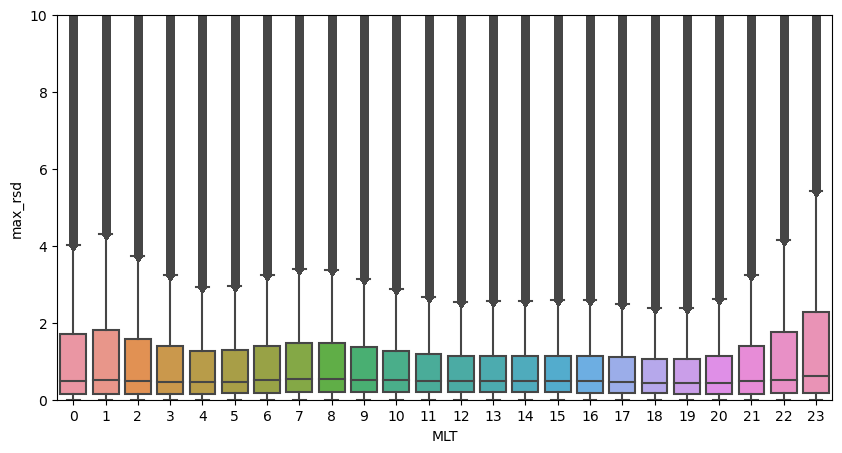

In [7]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
# plottinga  boxplot of max_rsd as a function of MLT
sns.boxplot(total_df["MLT"], total_df["max_rsd"])
plt.ylim(0,10)
plt.show()

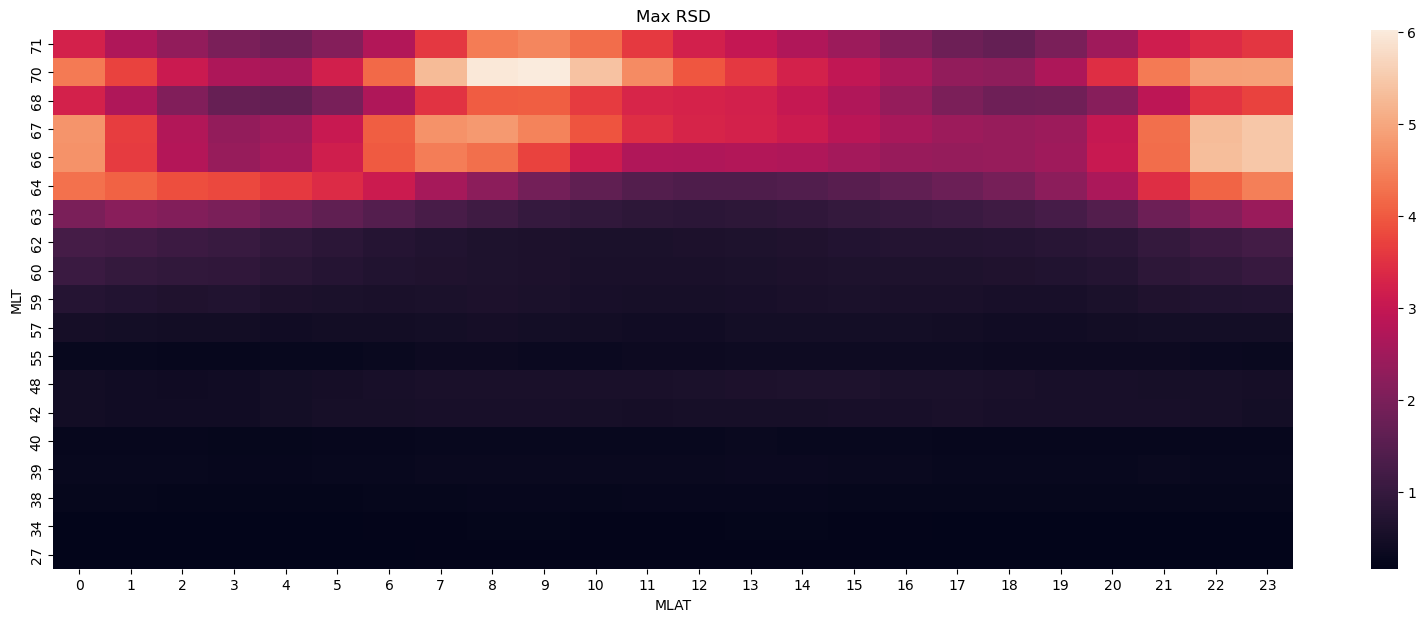

In [8]:
# transfering the grouped dataframe to a pivot table
pivot_median = simplified_df.pivot_table(index="mlat", columns="MLT", values="median")
pivot_mean = simplified_df.pivot_table(index="mlat", columns="MLT", values="mean")
pivot_std = simplified_df.pivot_table(index="mlat", columns="MLT", values="std")


# reversing the order of the pivot tabels for plotting
# pivot_median = pivot_median.iloc[::-1]
# pivot_std = pivot_std.iloc[::-1]
# pivot_mean = pivot_mean.iloc[::-1]

# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax = sns.heatmap(pivot_mean, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("MLAT")
ax.set_ylabel("MLT")
ax.set_title('Max RSD')
plt.show()

In [9]:
# manually writing a precision-recall curve for the continuious data
def continuious_precision_recall(y_true, y_pred):
    precision, recall = [], []
    for threshold in tqdm(np.linspace(0, y_pred.max(), 100)):
        y_pred_class = np.where(y_pred > threshold, 1, 0)
        y_true_class = np.where(y_true > threshold, 1, 0)
        tn, fn, fp, tp = confusion_matrix(y_true_class, y_pred_class).ravel()
        print(f'tp: {tp}, fp: {fp}, fn: {fn}, tn: {tn}')
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))

    # s1 = slice(None, None, -1)
    # precision = np.array(precision)[s1]
    # recall = np.array(recall)[s1]
    # print(precision)
    # print(recall)

    # reversing the order of the precision and recall
    precision = np.array(precision)[::-1]
    recall = np.array(recall)[::-1]
    return np.hstack((precision,1)), np.hstack((recall,0))

In [10]:
def calculating_hss(y_true, y_pred, thresholds):
	# calculating the true positive, false positive, false negative, and true negative
	hss_scores = []
	for threshold in thresholds:
		y_pred_class = np.where(y_pred > threshold, 1, 0)
		y_true_class = np.where(y_true > threshold, 1, 0)
		tn, fp, fn, tp = confusion_matrix(y_true_class, y_pred_class).ravel()
		hss = (2 * (tp * tn - fn * fp)) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn))
		hss_scores.append(hss)
	return hss_scores

In [11]:
for region in REGIONS:
	results_dict[region]['hss_scores'] = calculating_hss(results_dict[region]['results_df']['actual'], results_dict[region]['results_df']['predicted_mean'], results_dict[region]['thresholds'])


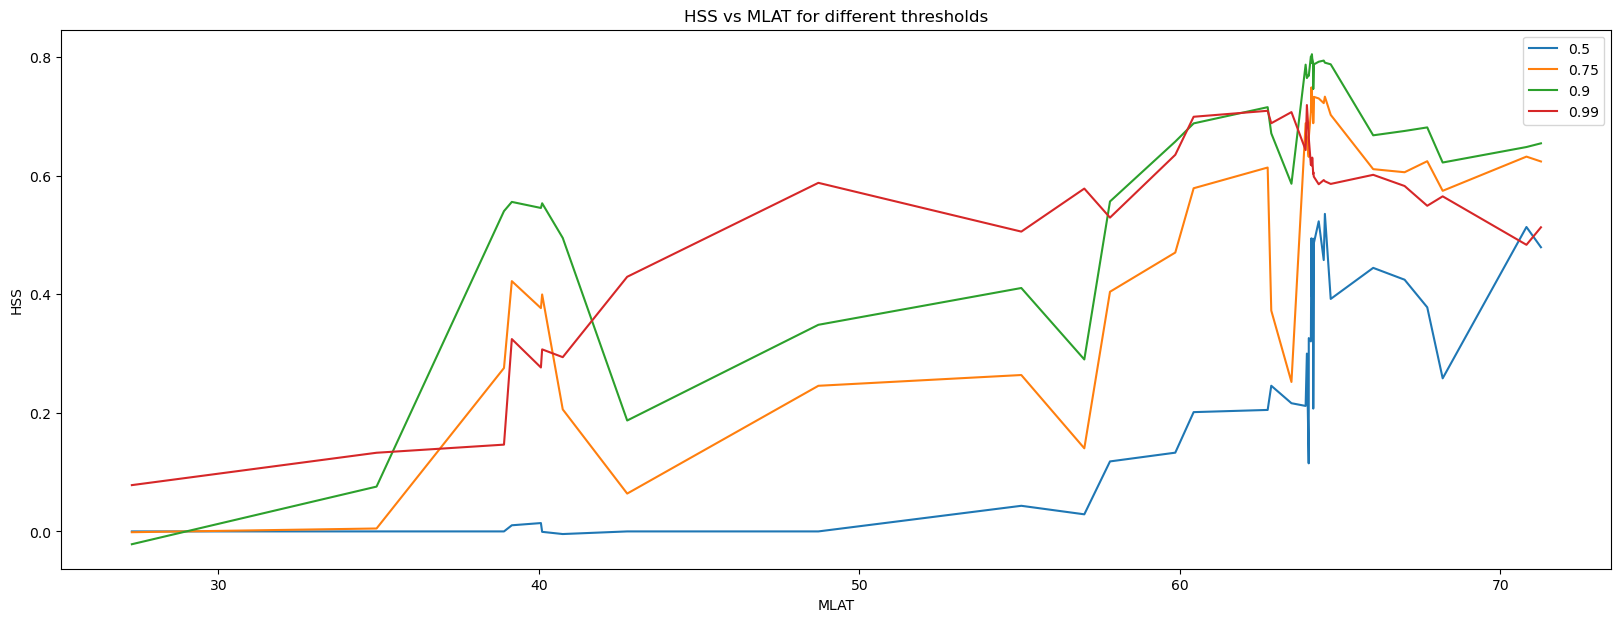

In [12]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
for i in range(len(thresholds)):
	plotting_df = pd.DataFrame({'hss':[results_dict[region]['hss_scores'][i] for region in REGIONS],
		 						'mlat':[results_dict[region]['mlat'] for region in REGIONS]})
	plotting_df = plotting_df.sort_values(by='mlat')
	ax.plot(plotting_df['mlat'], plotting_df['hss'], label=f'{thresholds[i]}')
ax.legend()
ax.set_xlabel('MLAT')
ax.set_ylabel('HSS')
ax.set_title('HSS vs MLAT for different thresholds')
plt.show()


In [13]:
temp_df = results_dict[387]['results_df'].copy()
temp_df.set_index('dates', inplace=True)
combined = temp_df.join(results_dict[387]['max_rsd'][['MLT', 'max_rsd_station']], how='left')
print(combined)

                     predicted_mean  predicted_std    actual   MLT  \
dates                                                                
2010-10-10 00:00:00        0.499031       0.243868  0.863738  2.52   
2010-10-10 00:01:00        0.532458       0.275007  0.863738  2.53   
2010-10-10 00:02:00        0.612185       0.308246  0.863738  2.55   
2010-10-10 00:03:00        0.581169       0.301363  0.863738  2.57   
2010-10-10 00:04:00        0.571797       0.289269  0.863738  2.58   
...                             ...            ...       ...   ...   
2017-09-29 23:55:00        5.971959       2.895065  5.640886  2.43   
2017-09-29 23:56:00        5.807911       2.818758  5.640886  2.45   
2017-09-29 23:57:00        5.508312       2.650460  5.640886  2.47   
2017-09-29 23:58:00        5.242916       2.512522  5.640886  2.48   
2017-09-29 23:59:00        4.843146       2.315751  5.640886  2.50   

                    max_rsd_station  
dates                                
2010-10-10 00

In [14]:
total_df = pd.DataFrame()
for region in REGIONS:
	temp_df = results_dict[region]['results_df'].copy()
	temp_df.set_index('dates', inplace=True)
	combined = temp_df.join(results_dict[region]['max_rsd'][['MLT', 'max_rsd_station']], how='left')
	combined['diff'] = combined['predicted_mean'] - combined['actual']
	combined['MLT'] = combined['MLT'].astype(int)
	combined['mlat'] = results_dict[region]['mlat'].astype(int)
	combined.loc[combined['MLT']==24, 'MLT'] = 0
	total_df = pd.concat([total_df, combined], axis=0, ignore_index=True)

grouped_diff = total_df.groupby(['MLT', 'mlat'])['diff'].agg(['mean', 'median', 'std', 'count'])
print(grouped_diff['mean'].min())

grouped_std = total_df.groupby(['MLT', 'mlat'])['predicted_std'].agg(['mean', 'median', 'std', 'count'])
print(grouped_std['mean'].min())

print(f"Minimum predicted std: {total_df['predicted_std'].min()}")

-9.134271623355021
0.225904181599617
Minimum predicted std: -0.11164841055870056


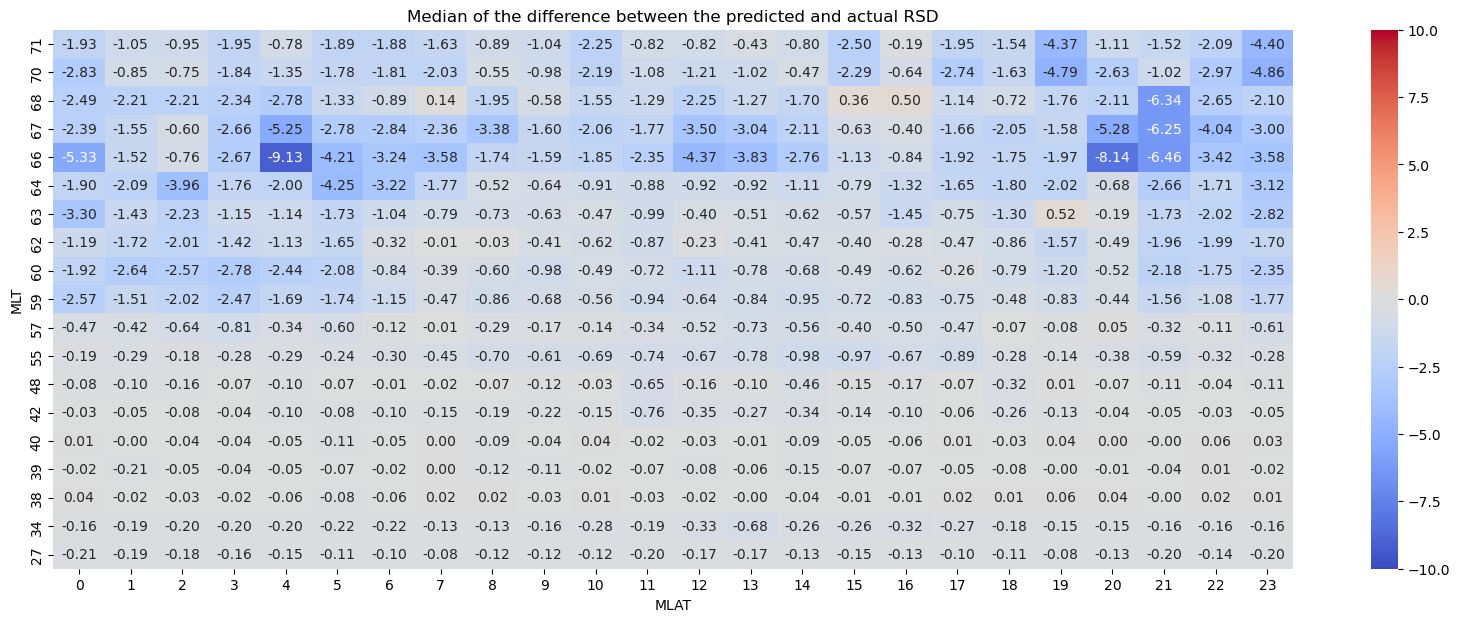

In [15]:
# transfering the grouped dataframe to a pivot table
pivot_median = grouped_diff.pivot_table(index='MLT', columns='mlat', values='median')
pivot_std = grouped_diff.pivot_table(index='MLT', columns='mlat', values='std')
pivot_mean = grouped_diff.pivot_table(index='MLT', columns='mlat', values='mean')

# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax = sns.heatmap(pivot_mean.T, ax=ax, cmap='coolwarm', vmin=-10, vmax=10, annot=True, fmt='.2f')
ax.invert_yaxis()
ax.set_xlabel('MLAT')
ax.set_ylabel('MLT')
ax.set_title('Median of the difference between the predicted and actual RSD')
plt.show()


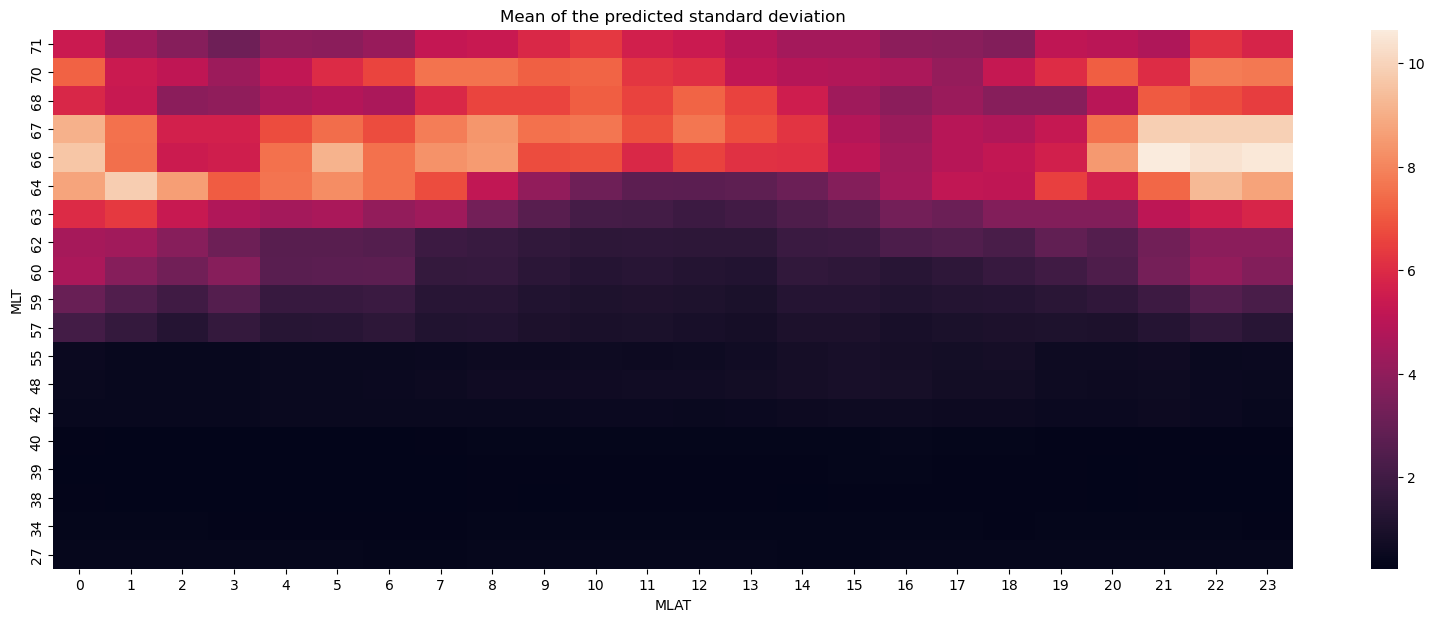

In [16]:
# transfering the grouped dataframe to a pivot table
pivot_median = grouped_std.pivot_table(index="MLT", columns="mlat", values="median")
pivot_mean = grouped_std.pivot_table(index="MLT", columns="mlat", values="mean")
pivot_std = grouped_std.pivot_table(index="MLT", columns="mlat", values="std")

# plotting the pivot table with mlat on the y-axis in decending order and the MLT on the x-axis in ascending order
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(111)
ax = sns.heatmap(pivot_mean.T, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("MLAT")
ax.set_ylabel("MLT")
ax.set_title("Mean of the predicted standard deviation")
plt.show()

In [35]:
with open('outputs/shap_values/non_twins_region_137_evaluation_dict.pkl', 'rb') as f:
	evaluation_dict = pickle.load(f)

temp_df = results_dict[137]['results_df'].copy()
temp_df.set_index('dates', inplace=True)
temp_df = temp_df['2017-09-01 00:00:00':]

In [36]:
evaluation_dict['2017-09-01']['ytest'].shape
temp_df.reset_index(inplace=True, drop=False)

In [48]:
def converting_shap_to_percentages(shap_values, features):
    if len(shap_values) > 1:
        all_shap_values = []
        for shap in shap_values:
            summed_shap_values = np.sum(shap, axis=1)
            summed_shap_values = summed_shap_values.reshape(
                summed_shap_values.shape[0], summed_shap_values.shape[1]
            )
            shap_df = pd.DataFrame(summed_shap_values, columns=features)
            perc_df = (shap_df.div(shap_df.abs().sum(axis=1), axis=0)) * 100
            all_shap_values.append(perc_df)

    else:
        summed_shap_values = np.sum(shap_values, axis=1)
        summed_shap_values = summed_shap_values.reshape(
            summed_shap_values.shape[0], summed_shap_values.shape[1]
        )
        shap_df = pd.DataFrame(summed_shap_values, columns=features)
        perc_df = (shap_df.div(shap_df.abs().sum(axis=1), axis=0)) * 100
        all_shap_values = perc_df

    return all_shap_values


def preparing_shap_values_for_plotting(df, dates):
    df = handling_gaps(df, 1000, dates)

    # Seperating the positive contributions from the negative for plotting
    pos_df = df.mask(df < 0, other=0)
    neg_df = df.mask(df > 0, other=0)

    pos_dict, neg_dict = {}, {}

    # Creating numpy arrays for each parameter
    for pos, neg in zip(pos_df, neg_df):
        pos_dict[pos] = pos_df[pos].to_numpy()
        neg_dict[neg] = neg_df[neg].to_numpy()

    return pos_dict, neg_dict, df.index


def handling_gaps(df, threshold, dates):
    """
    Function for keeping blocks of nans in the data if there is a maximum number of data points between sucessive valid data.
    If the number of nans is too large between sucessive data points it will drop those nans.

    Args:
            df (pd.DataFrame): data to be processed

    Returns:
            pd.DataFrame: processed data
    """
    df["Date_UTC"] = dates
    df.set_index("Date_UTC", inplace=True)
    df.index = pd.to_datetime(df.index)

    start_time = pd.to_datetime("2009-07-19")
    end_time = pd.to_datetime("2017-12-31")
    date_range = pd.date_range(start_time, end_time, freq="min")

    full_time_df = pd.DataFrame(index=date_range)

    df = full_time_df.join(df, how="left")

    # creting a column in the data frame that labels the size of the gaps
    df["gap_size"] = (
        df[df.columns[1]]
        .isna()
        .groupby(df[df.columns[1]].notna().cumsum())
        .transform("sum")
    )

    # setting teh gap size column to nan if the value is above the threshold, setting it to 0 otherwise
    df["gap_size"] = np.where(df["gap_size"] > threshold, np.nan, 0)

    # dropping nans from the subset of the gap size column
    df.dropna(inplace=True, subset=["gap_size"])

    # dropping the gap size column
    df.drop(columns=["gap_size"], inplace=True)

    return df


def plotting_shap_values(evaluation_dict, results_df, features, region):

    for key in evaluation_dict.keys():
        


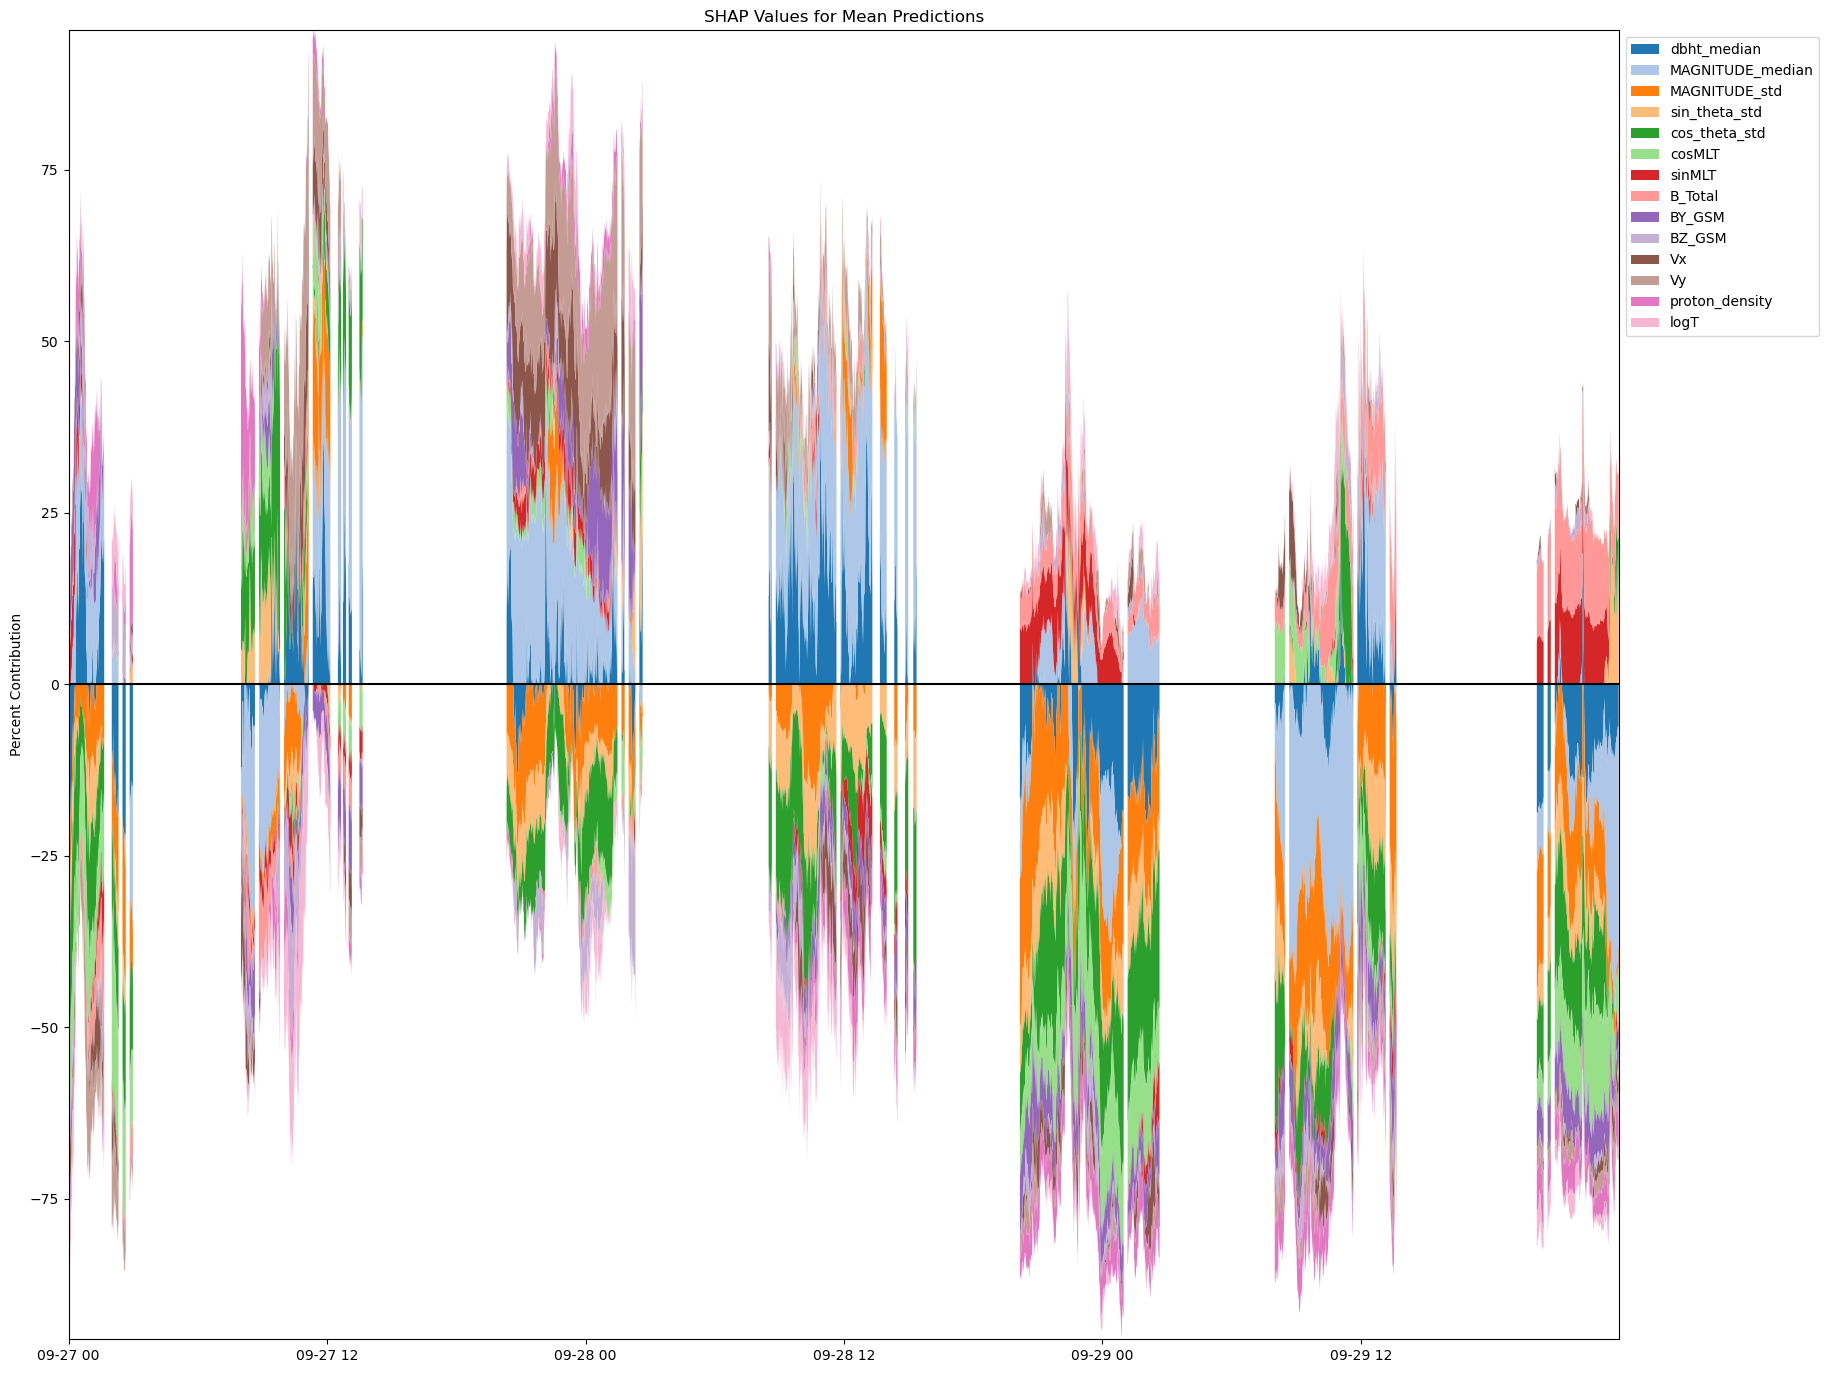

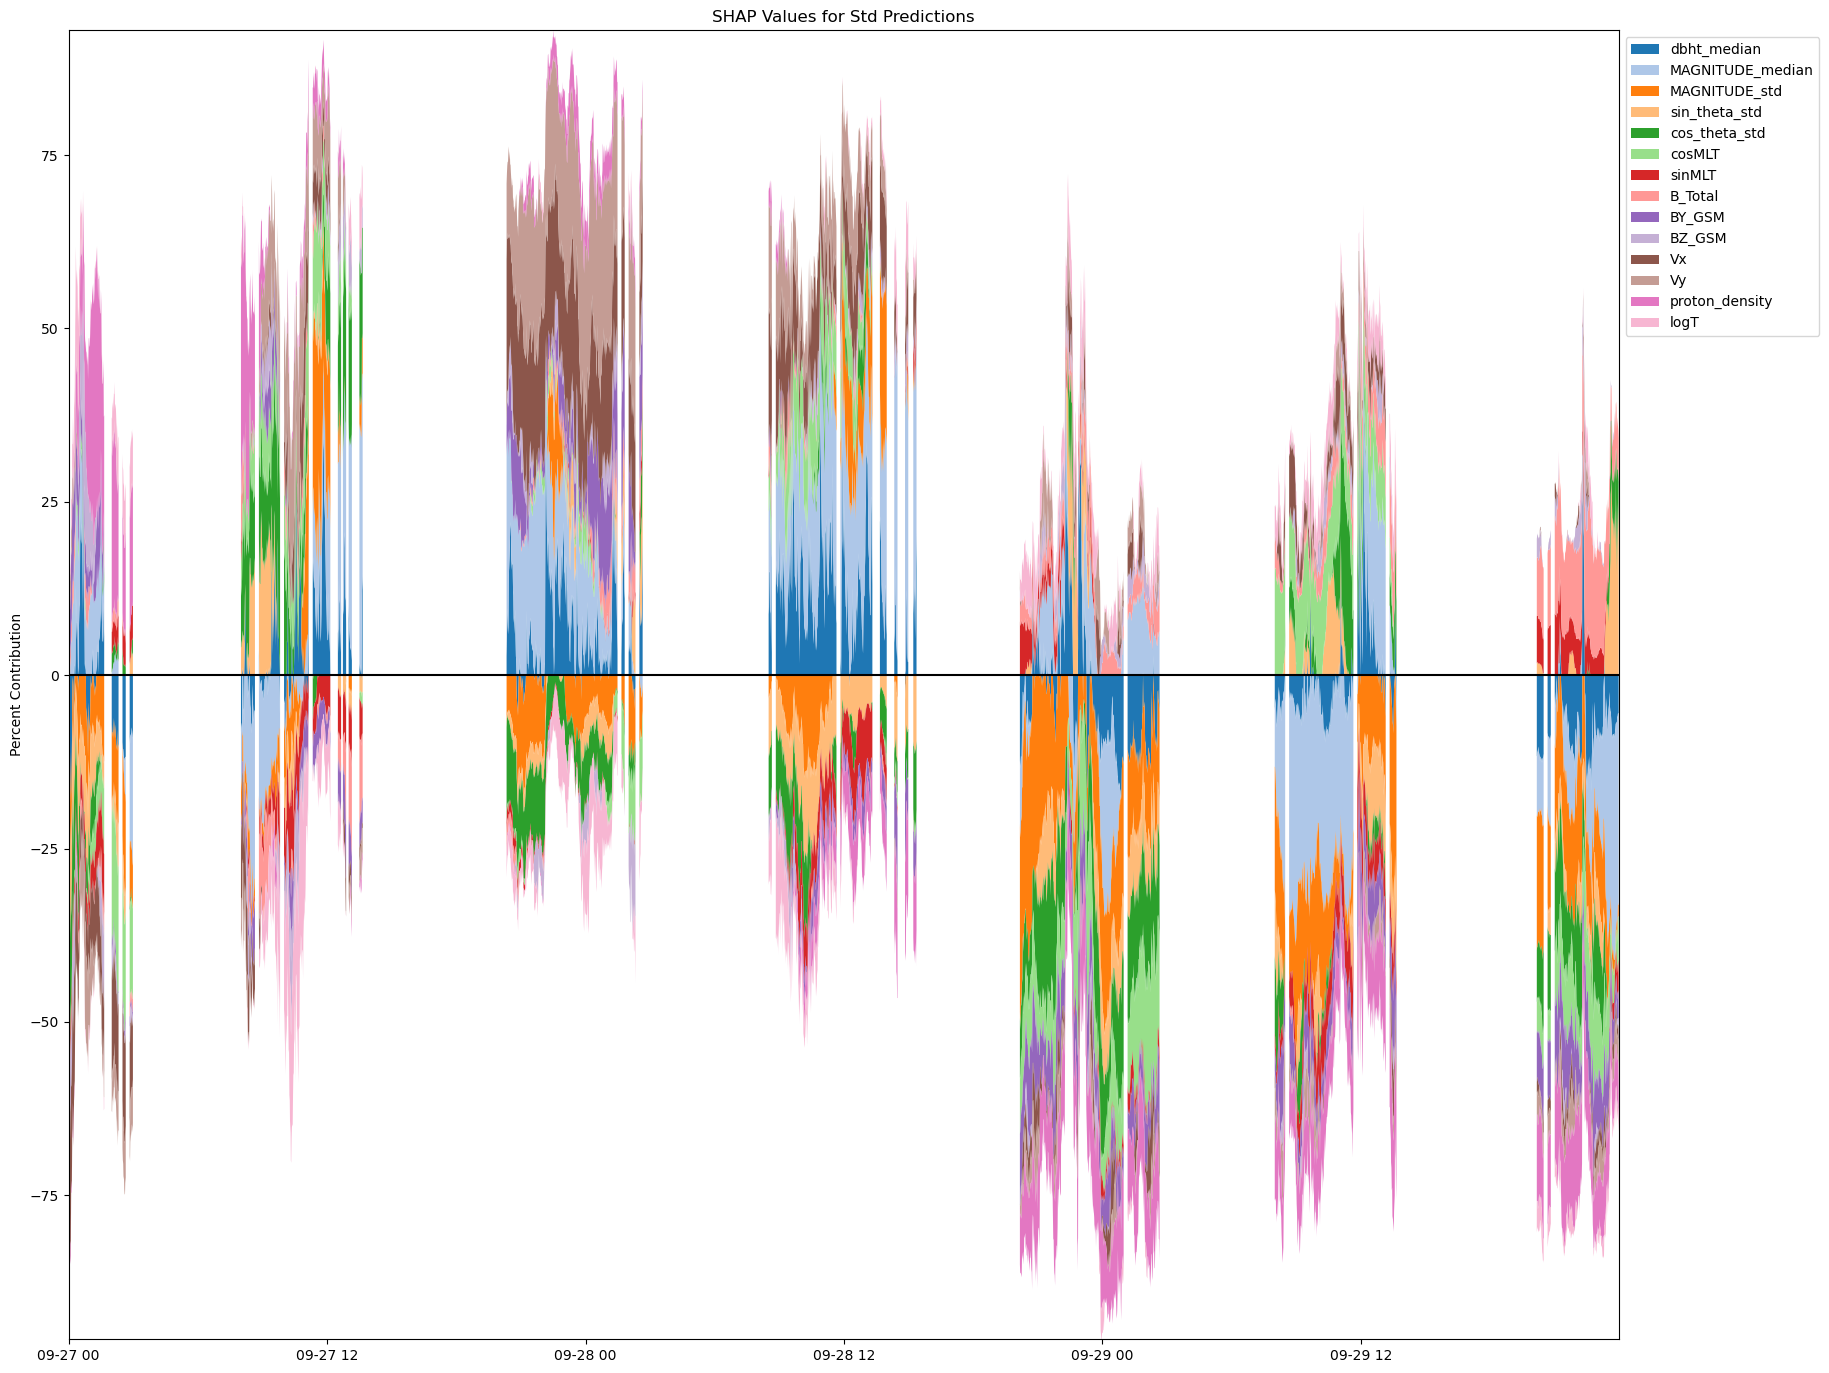

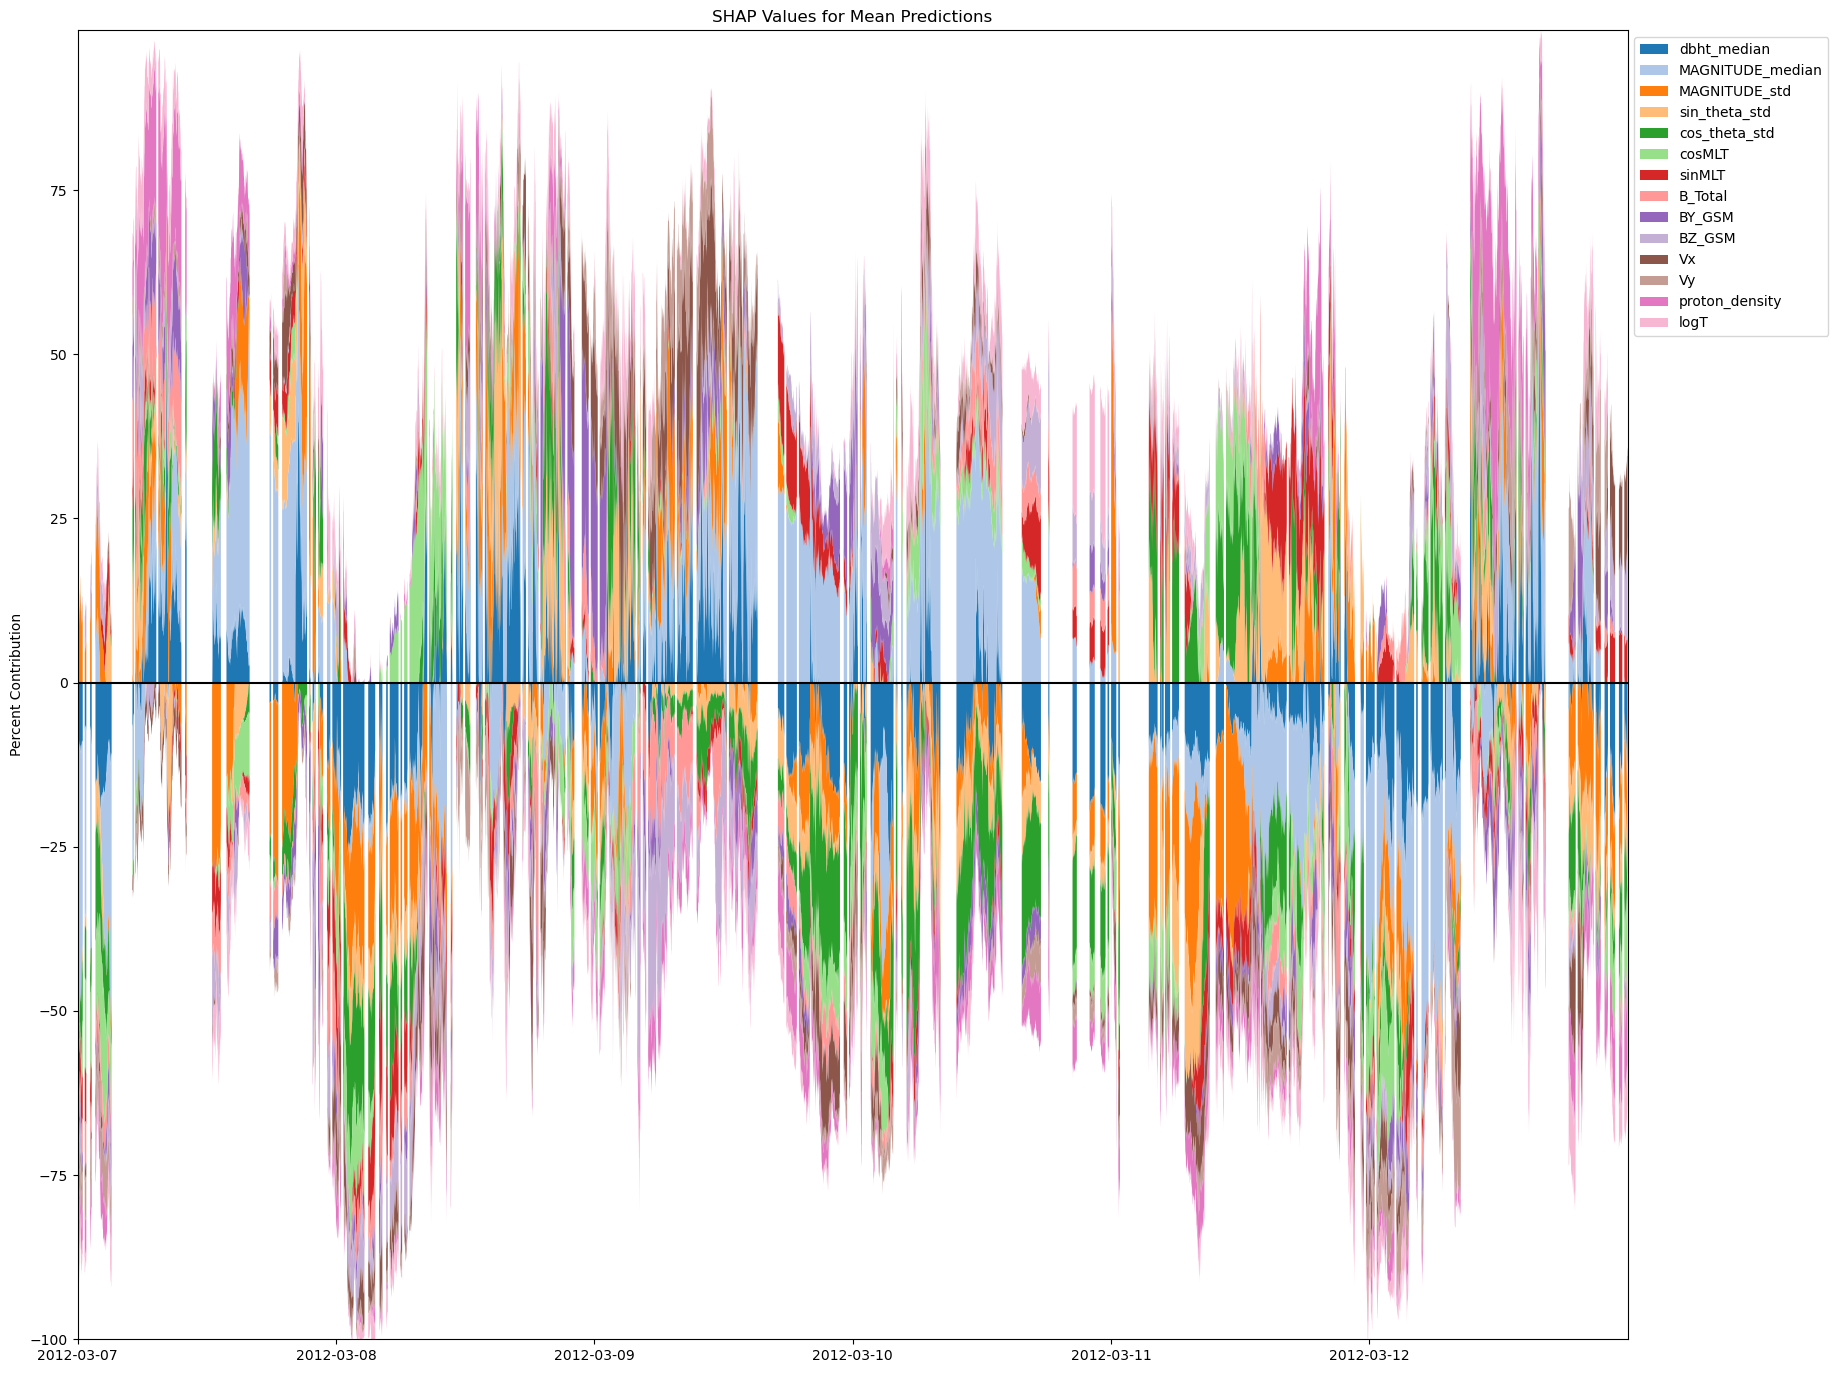

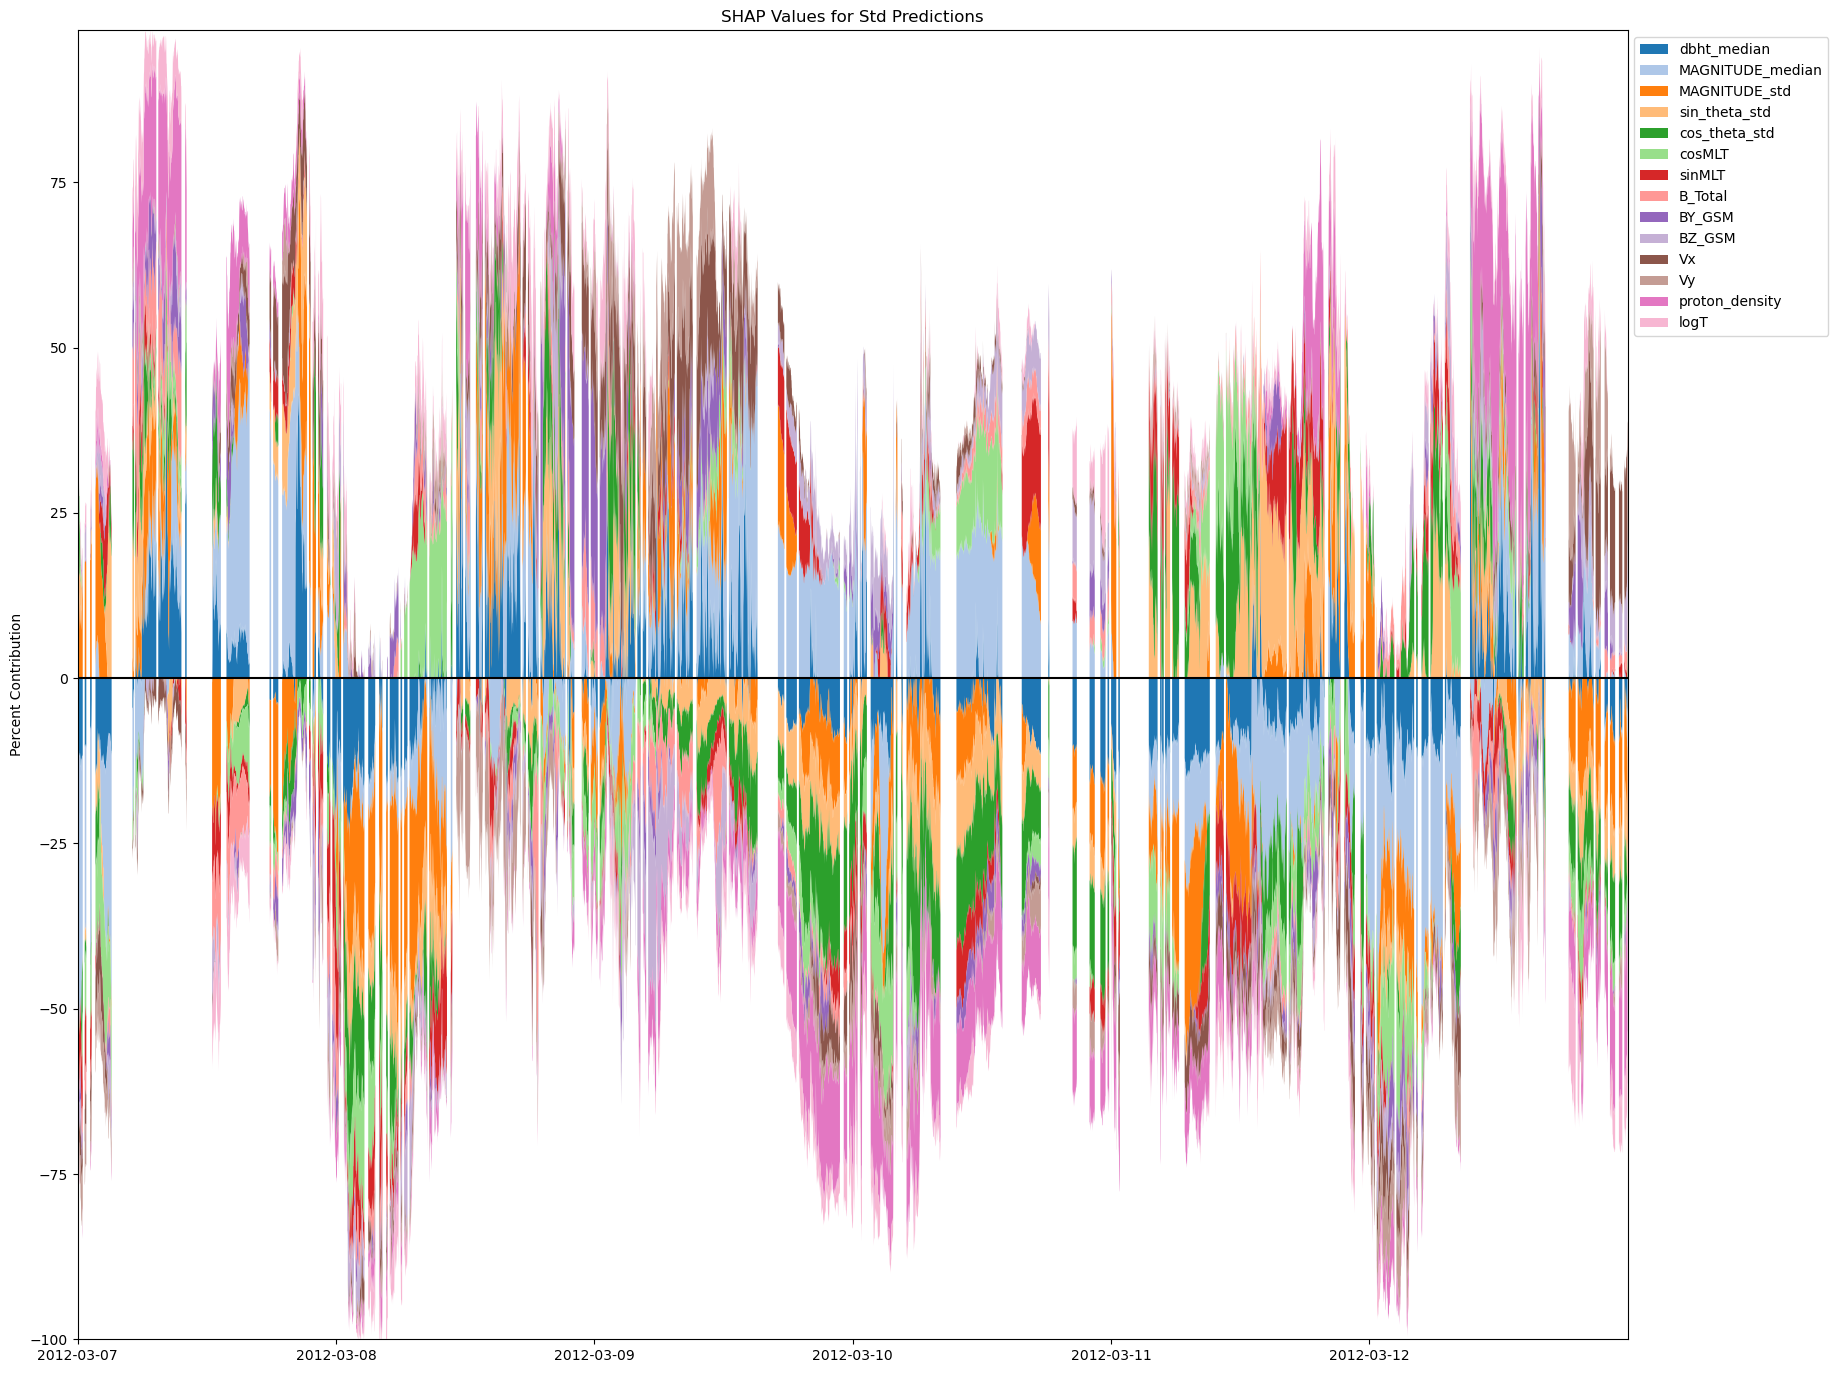

In [49]:


shap_percentages = converting_shap_to_percentages(evaluation_dict[key]["shap_values"], features)
mean_pos_dict, mean_neg_dict, mean_dates = preparing_shap_values_for_plotting(shap_percentages[0], evaluation_dict[key]["Date_UTC"])
std_pos_dict, std_neg_dict, std_dates = preparing_shap_values_for_plotting(shap_percentages[1], evaluation_dict[key]["Date_UTC"])